In [2]:
import pandas as pd
import yfinance as yf
from collections import defaultdict
from statistics import stdev, mean
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# download the list of _current_ Nasdaq-100 stocks
url = 'https://en.m.wikipedia.org/wiki/Nasdaq-100'
df_nasdaq_100_list = pd.read_html(url, attrs={'id': "constituents"}, index_col='Symbol')[0]
tickers = list(df_nasdaq_100_list.index)
# download 5 years worth of daily closing prices for all 100 stocks
df_nasdaq_100 = yf.download(tickers, '2020-01-01', '2024-12-31')
df_nasdaq_100.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  101 of 101 completed


Price           Close                                                       \
Ticker           AAPL ABNB        ADBE         ADI         ADP        ADSK   
Date                                                                         
2020-01-02  72.716095  NaN  334.429993  109.912376  153.205917  187.830002   
2020-01-03  72.009109  NaN  331.809998  107.977516  152.882080  184.949997   
2020-01-06  72.582901  NaN  333.709991  106.708885  153.088959  187.119995   
2020-01-07  72.241562  NaN  333.390015  109.136597  151.235947  187.500000   
2020-01-08  73.403641  NaN  337.869995  110.122299  152.657166  189.949997   

Price                                                    ...     Volume  \
Ticker            AEP       AMAT        AMD        AMGN  ...       TSLA   
Date                                                     ...              
2020-01-02  77.261696  59.224575  49.099998  204.452927  ...  142981500   
2020-01-03  77.179016  58.281940  48.599998  203.064941  ...  266677500   
2020-01-06  77.435280  57.025085  48.389999  204.623215  ...  151995000   
2020-01-07  77.451820  58.672329  48.250000  202.698792  ...  268231500   
2020-01-08  77.220360  58.634235  47.830002  202.852051  ...  467164500   

Price                                                                       \
Ticker           TTD     TTWO      TXN     VRSK     VRTX      WBD     WDAY   
Date                                                                         
2020-01-02  22197000  1114200  4614000   845100  1334300  3249300  1503000   
2020-01-03  13736000   729100  4057200   876900   943400  3599600  1276300   
2020-01-06  18238000  1678700  4345400   656200  1436600  2416900  1623300   
2020-01-07  21999000  1179300  7184100  1514700  1027700  3102000  2404100   
2020-01-08  20523000  1665900  3546900   773100  1802600  3674100  2819900   

Price                         
Ticker          XEL       ZS  
Date                          
2020-01-02  2915400  1377200  
2020-01-03  2422500  1165200  
2020-01-06  2217100  1534600  
2020-01-07  1861100  1714900  
2020-01-08  4828900  3232500  

[5 rows x 505 columns]

In [26]:
def take(series, i):
    return [x[i] for x in series]

def first(series):
    return take(series, 0)

def second(series):
    return take(series, 1)

def extract_series(df, ticker, metric):
    return list(zip(list(df.index.astype(str)), list(df[metric][ticker])))

def execute_strategy(prices, take_profit_price=None, stop_loss_price=None):
    for days, daily_price in enumerate(prices):
        if take_profit_price is not None:
            if daily_price >= take_profit_price:
                return take_profit_price, days+1
        if stop_loss_price is not None:
            if daily_price <= stop_loss_price:
                return stop_loss_price, days+1
    return prices[-1], len(prices)

def strategy_returns(prices, position_length, take_profit=None, stop_loss=None):
    returns = []
    for i, start_price in enumerate(prices[:-(position_length)]):
        final_price, active_days = execute_strategy(
            prices=prices[i+1:i+position_length+1],
            take_profit_price=start_price*take_profit if take_profit is not None else None,
            stop_loss_price=start_price*stop_loss if stop_loss is not None else None,
        )
        r = (final_price - start_price) / start_price
        daily_normalized_return = np.exp(np.log(1+r)/active_days)-1
        returns.append(daily_normalized_return)
    return returns

daily_strategy = lambda prices: strategy_returns(prices, position_length=1, take_profit=None, stop_loss=None)

# metric functions:

def win_ratio(returns):
    return sum(1 for r in returns if r > 0) / len(returns)

def mean_return(returns):
    return np.mean(returns)

def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

# goodness functions:

def above_diagonal(xs, ys):
    return sum(y > x for x, y in zip(xs, ys)) / len(xs)

def mean_difference(xs, ys):
    return np.mean([y - x for x, y in zip(xs, ys)])

def plot_strategies(df, tickers, price_metric, metric_func, strategy_func_x, strategy_func_y, title='', axis_label_x='', axis_label_y=''):
    metric_xs, metric_ys, tickers_xy = [], [], []
    for ticker in tickers:
        prices = second(extract_series(df, ticker, price_metric))
        returns = strategy_func_x(prices)
        metric_x = metric_func(returns)
        if np.isnan(metric_x): continue
        returns = strategy_func_y(prices)
        metric_y = metric_func(returns)
        if np.isnan(metric_y): continue
        metric_xs.append(metric_x)
        metric_ys.append(metric_y)
        tickers_xy.append(ticker)
    xy_min = min(min(metric_xs), min(metric_ys))
    xy_max = max(max(metric_xs), max(metric_ys))
    diagonal = np.linspace(xy_min, xy_max, 100)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(diagonal, diagonal, '--')
    colors = ['green' if y > x else 'red' for x, y in zip(metric_xs, metric_ys)]
    ax.set(xlabel=axis_label_x, ylabel=axis_label_y, title=title)
    ax.scatter(metric_xs, metric_ys, c=colors)
    for x, y, ticker in zip(metric_xs, metric_ys, tickers_xy):
        ax.annotate(ticker, (x, y))

def strategy_goodness(df, tickers, price_metric, metric_func, strategy_func_x, strategy_func_y, goodness_func):
    metric_xs, metric_ys = [], []
    for ticker in tickers:
        prices = second(extract_series(df, ticker, price_metric))
        returns = strategy_func_x(prices)
        metric_x = metric_func(returns)
        if np.isnan(metric_x): continue
        returns = strategy_func_y(prices)
        metric_y = metric_func(returns)
        if np.isnan(metric_y): continue
        metric_xs.append(metric_x)
        metric_ys.append(metric_y)
    return goodness_func(metric_xs, metric_ys)

def plot_goodness(df, tickers, price_metric, metric_func, metric_text, take_profit_mul=1.0):
    monthly_trading_days = 21
    base_delta = 0.1
    position_lengths = [m * monthly_trading_days for m in [1, 3, 6, 9, 12]]
    qs = defaultdict(lambda: [])
    for position_length in position_lengths:
        for delta in np.arange(0, 1.0 - base_delta, 0.05): # [0.15 .. 0.95]
            q = strategy_goodness(
                df=df, tickers=tickers, price_metric='Close',
                metric_func=metric_func,
                strategy_func_x=lambda prices: strategy_returns(prices, position_length, take_profit=1.0 + base_delta,                         stop_loss=1.0 - base_delta),
                strategy_func_y=lambda prices: strategy_returns(prices, position_length, take_profit=1.0 + base_delta + take_profit_mul*delta, stop_loss=1.0 - base_delta - delta),
                goodness_func=mean_difference,
            )
            qs[position_length].append((delta, q))
    legends = []
    plt.figure(figsize=(7, 7))
    for position_length in position_lengths:
        legends.append(f'position length={int(position_length/21)} mos')
        plt.plot(first(qs[position_length]), second(qs[position_length]), marker='o')
    plt.title(f'mean {metric_text} difference between base strategy of Δ=10% take profit/stop loss and challenger strategies with higher Δs')
    plt.xlabel(f'challenger strategy take profit and stop loss Δ over base')
    plt.ylabel(f'mean {metric_text} difference vs base strategy')
    plt.xlim((0.0, 1.0))
    plt.legend(legends)

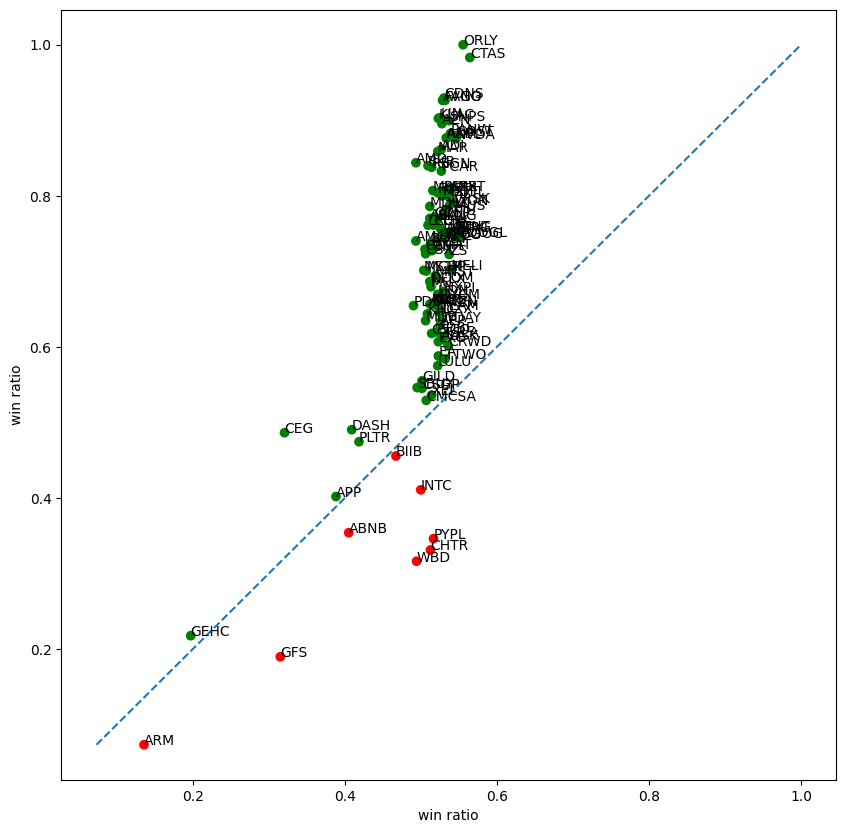

In [5]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=win_ratio,
    strategy_func_x=daily_strategy,
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.5, stop_loss=0.5),
    axis_label_x='win ratio', axis_label_y='win ratio',
)

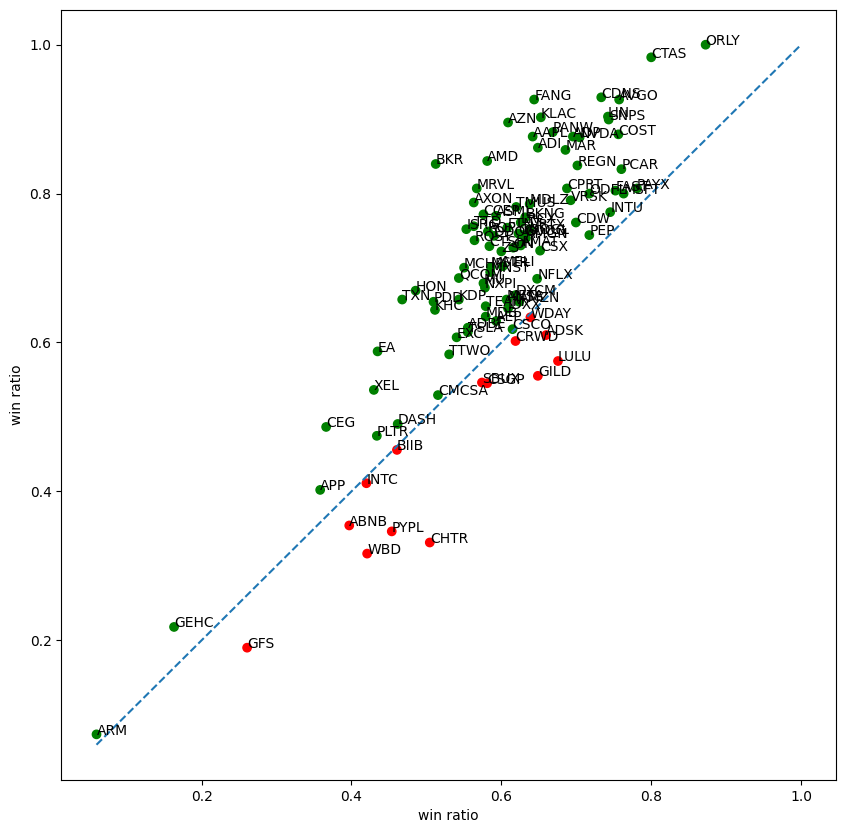

In [6]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=win_ratio,
    strategy_func_x=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.1, stop_loss=0.9),
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.5, stop_loss=0.5),
    axis_label_x='win ratio', axis_label_y='win ratio',
)

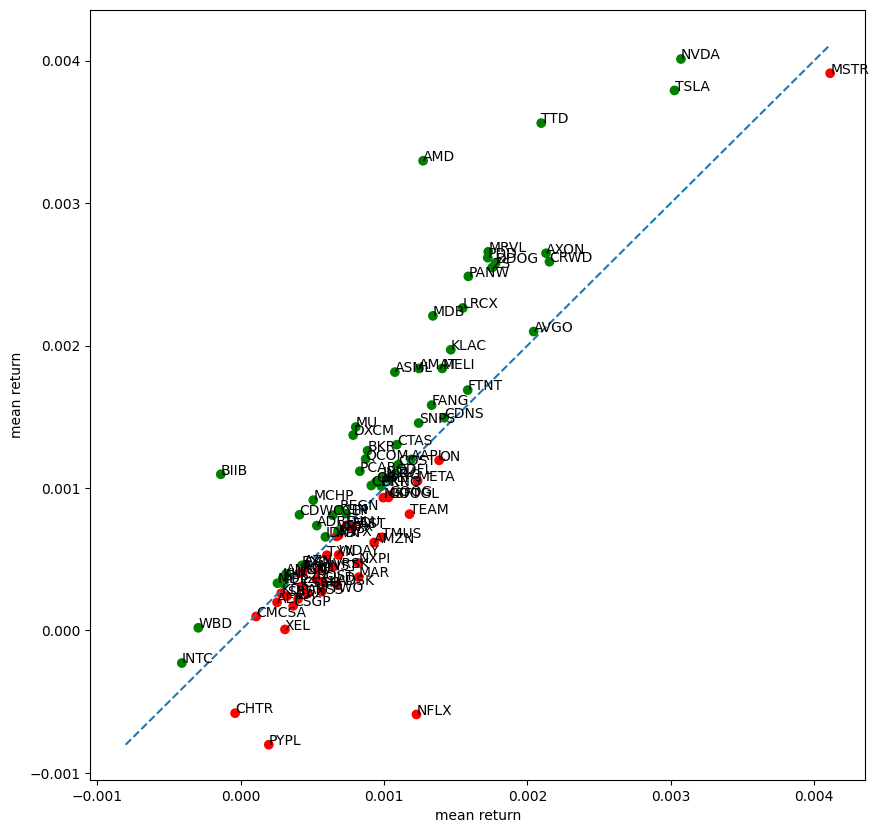

In [7]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=mean_return,
    strategy_func_x=daily_strategy,
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.5, stop_loss=0.5),
    axis_label_x='mean return', axis_label_y='mean return',
)

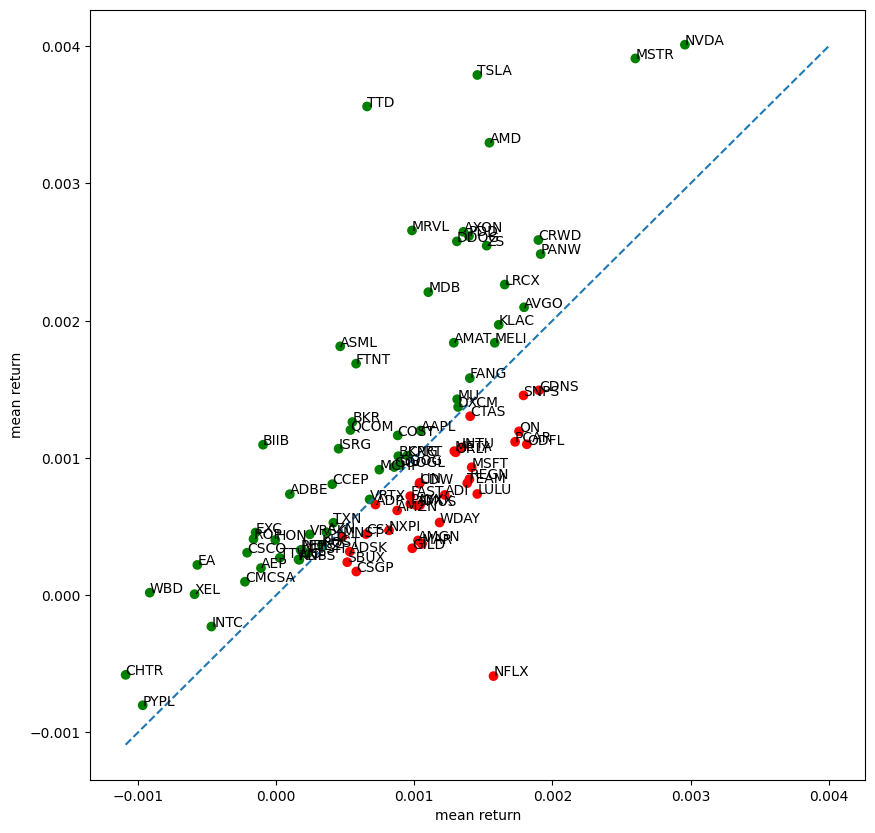

In [8]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=mean_return,
    strategy_func_x=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.1, stop_loss=0.9),
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.5, stop_loss=0.5),
    axis_label_x='mean return', axis_label_y='mean return',
)

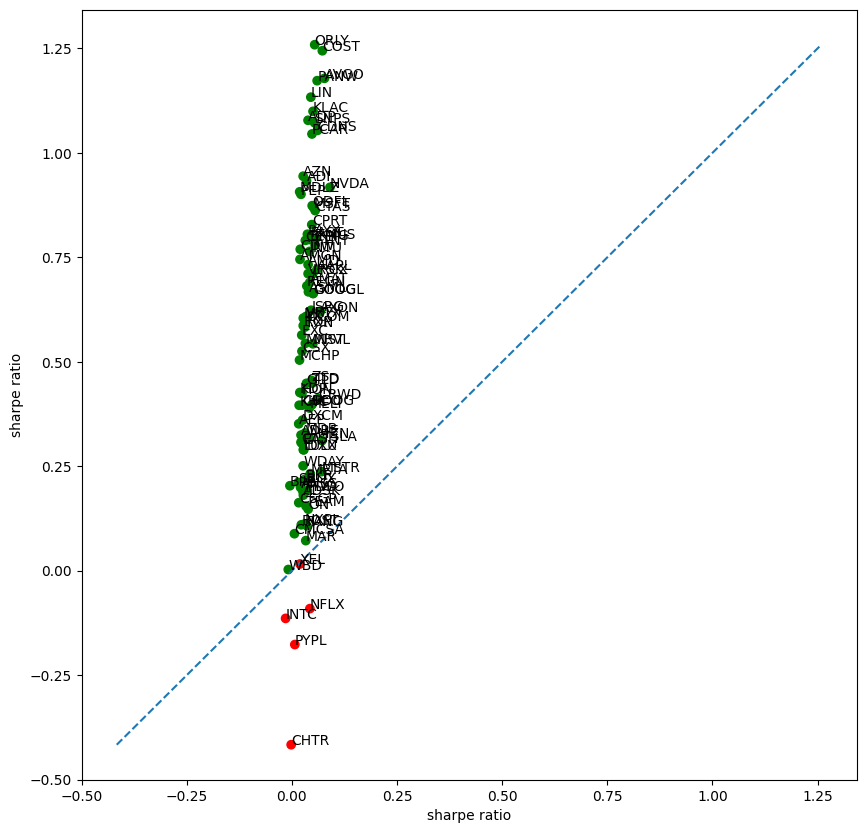

In [9]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=sharpe_ratio,
    strategy_func_x=daily_strategy,
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.5, stop_loss=0.5),
    axis_label_x='sharpe ratio', axis_label_y='sharpe ratio',
)

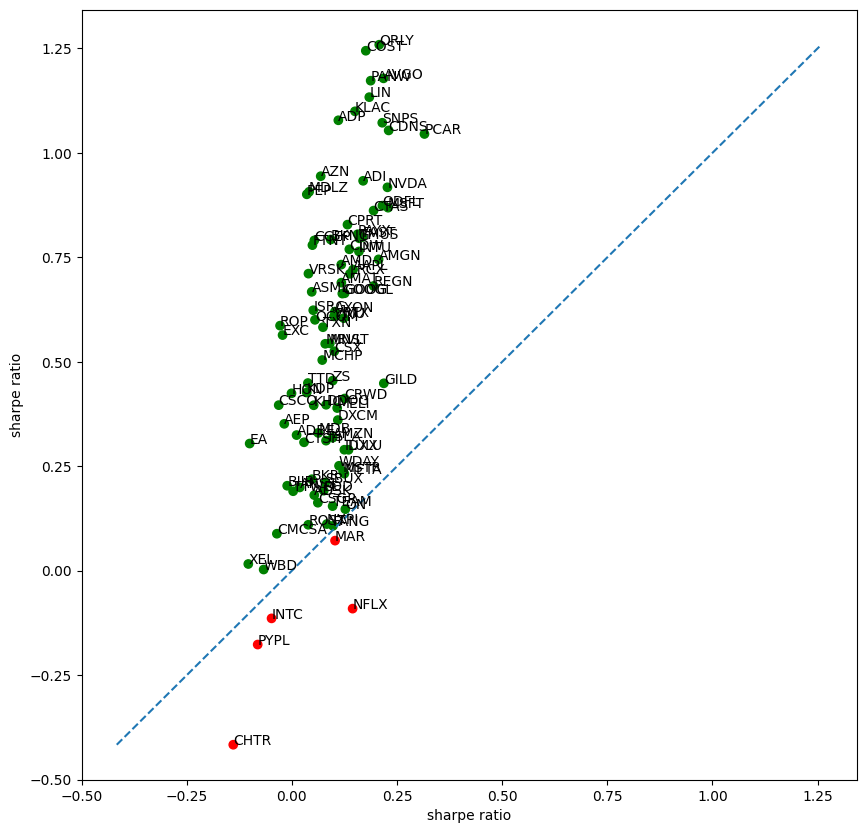

In [10]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=sharpe_ratio,
    strategy_func_x=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.1, stop_loss=0.9),
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=252, take_profit=1.5, stop_loss=0.5),
    axis_label_x='sharpe ratio', axis_label_y='sharpe ratio',
)

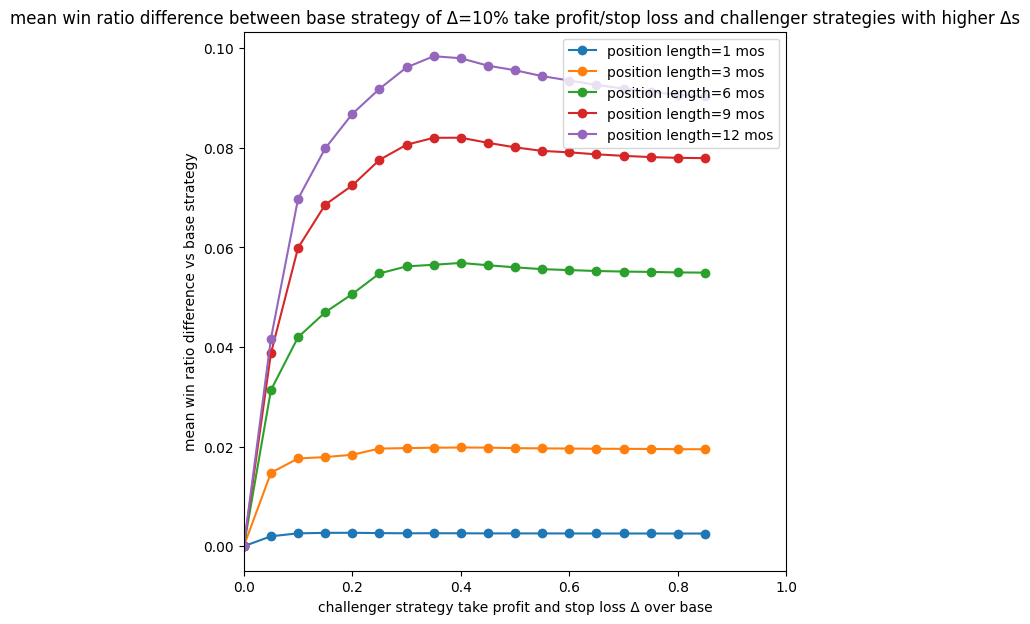

In [11]:
plot_goodness(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=win_ratio, metric_text="win ratio",
)

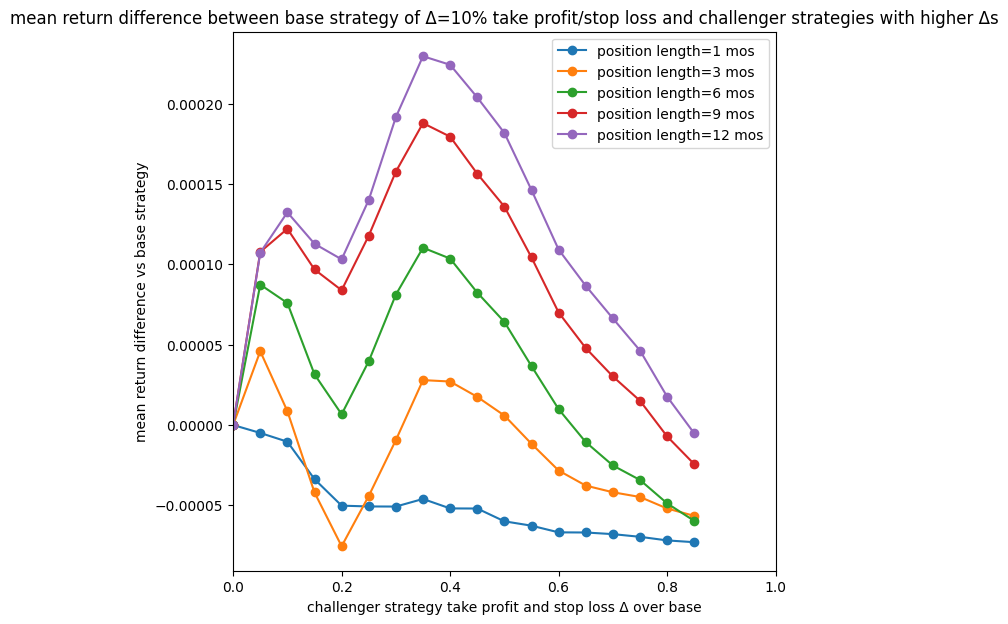

In [12]:
plot_goodness(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=mean_return, metric_text="return",
)

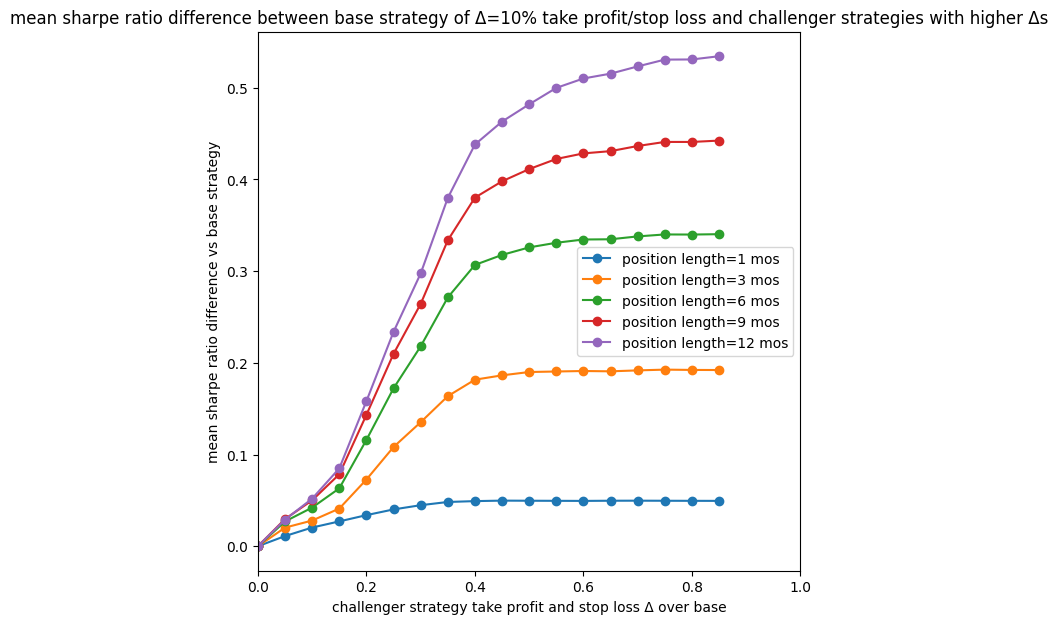

In [13]:
plot_goodness(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=sharpe_ratio, metric_text="sharpe ratio",
)

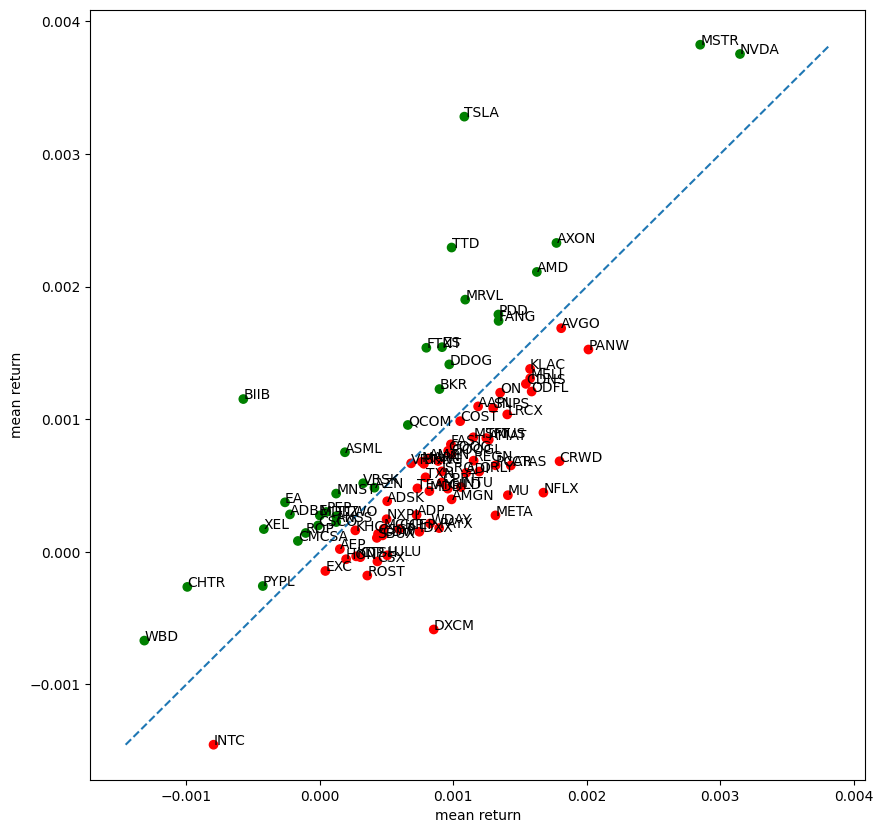

In [14]:
plot_strategies(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=mean_return,
    strategy_func_x=lambda prices: strategy_returns(prices, position_length=3*21, take_profit=1.1, stop_loss=0.9),
    strategy_func_y=lambda prices: strategy_returns(prices, position_length=3*21, take_profit=1.3, stop_loss=0.7),
    axis_label_x='mean return', axis_label_y='mean return',
)

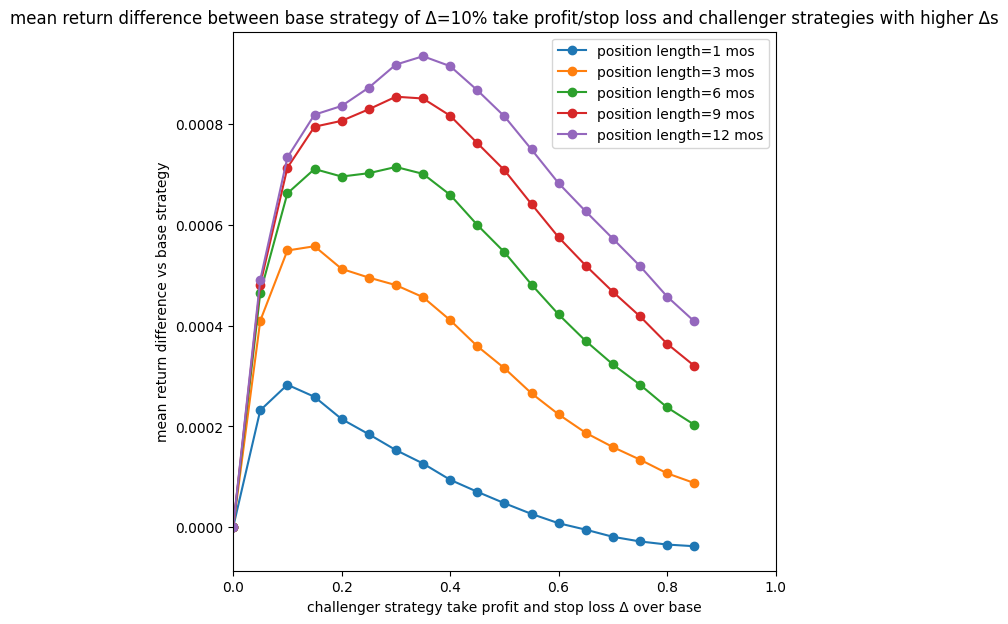

In [15]:
plot_goodness(
    df=df_nasdaq_100, tickers=tickers, price_metric='Close',
    metric_func=mean_return, metric_text="return",
    take_profit_mul=0.5,
)

In [16]:
market_annual = 1.08
market_daily = np.exp(np.log(market_annual)/252)
market_daily, market_daily**252

(np.float64(1.0003054475965094), np.float64(1.0799999999999923))

In [17]:
(market_daily+0.0008)**252

np.float64(1.321039509516581)

In [25]:
prices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
position_length = 3
for i, start_price in enumerate(prices[:-(position_length)]):
    print(start_price, prices[i+1:i+position_length+1],)

1 [2, 3, 4]
2 [3, 4, 5]
3 [4, 5, 6]
4 [5, 6, 7]
5 [6, 7, 8]
6 [7, 8, 9]
7 [8, 9, 10]
